In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.detection as afwDetect
from toolbox.image import zscale
from skimage import draw
plt.style.use('jpg')

def smooth_image(maskedImage, sigma):
    kWidth = (int(sigma * 7 + 0.5) // 2) * 2 + 1 # make sure it is odd
    gaussFunc = afwMath.GaussianFunction1D(sigma)
    gaussKernel = afwMath.SeparableKernel(kWidth, kWidth, gaussFunc, gaussFunc)
    convolvedImage = maskedImage.Factory(maskedImage.getBBox())
    afwMath.convolve(convolvedImage, maskedImage, gaussKernel, afwMath.ConvolutionControl())
    return convolvedImage

In [2]:
data_dir = os.environ.get('LOCAL_DATA')
fn = os.path.join(data_dir, 'calexp-HSC-I-9348-7,6.fits')
exposure = afwImage.ExposureF(fn)
disp  = afwDisplay.Display(1)
mi = exposure.getMaskedImage()
mask = mi.getMask()
psf = exposure.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
#afwImage.MaskU.addMaskPlane('DETECTED_NEGATIVE');

In [3]:
psf = exposure.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
fwhm = 2*np.sqrt(2*np.log(2))*sigma
ngrow = int(2.4*sigma + 0.5)
mi_smooth = smooth_image(mi, sigma)
print('psf fwhm =', round(fwhm*0.168, 2), 'arcsec')

psf fwhm = 0.52 arcsec


## High threshold detection

In [4]:
hi_val = 9.0
DETECTED_NEGATIVE = afwDetect.Threshold(hi_val, afwDetect.Threshold.STDEV)
fp_hi = afwDetect.FootprintSet(mi_smooth, DETECTED_NEGATIVE)
fp_hi = afwDetect.FootprintSet(fp_hi, ngrow, True)

## Low threshold detection

In [5]:
lo_val = 1.2
thresh_lo = afwDetect.Threshold(lo_val, afwDetect.Threshold.STDEV)
fp_lo = afwDetect.FootprintSet(mi_smooth, thresh_lo, 'DETECTED', 50)
fp_lo = afwDetect.FootprintSet(fp_lo, ngrow)

## Set masks and generate noise array

In [6]:
mask.clearMaskPlane(mask.getMaskPlane('DETECTED_NEGATIVE'))
mask.clearMaskPlane(mask.getMaskPlane('DETECTED'))
fp_hi.setMask(mask, 'DETECTED_NEGATIVE')
fp_lo.setMask(mask, 'DETECTED')
back_rms = mi.getImage().getArray()[mask.getArray()==0].std()
noise_array = back_rms*np.random.randn(mask.getArray().shape[0], mask.getArray().shape[1])
print('bacground rms =', back_rms)

bacground rms = 0.0554344


## Visualize segmentation maps

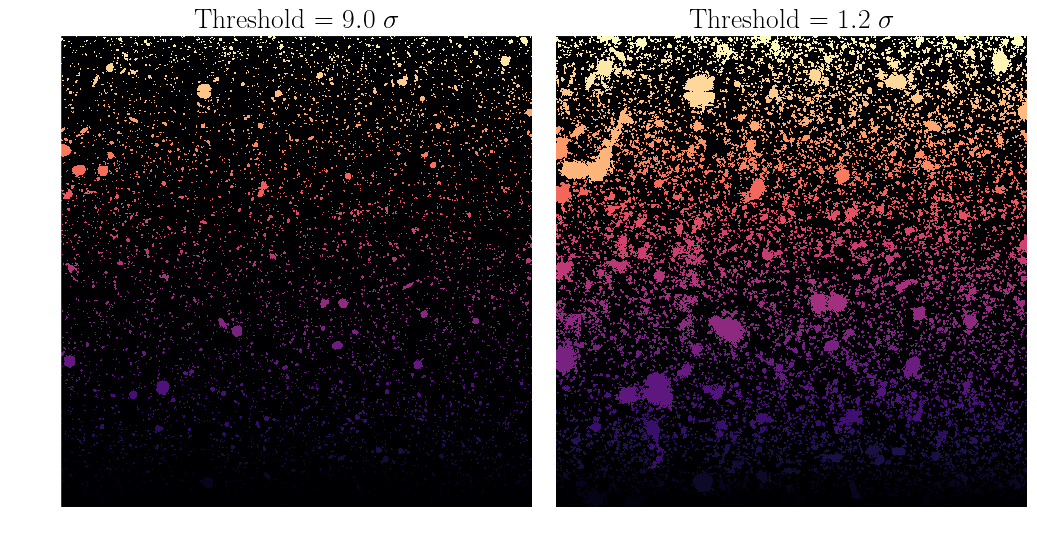

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.05)
seg_hi = fp_hi.insertIntoImage(True).getArray().copy()
seg_lo = fp_lo.insertIntoImage(True).getArray().copy()
seg_maps = [(seg_hi, hi_val), (seg_lo, lo_val)]
for i, (seg, val) in enumerate(seg_maps):
    ax[i].imshow(seg, origin='low', cmap=plt.cm.magma, aspect='equal')
    ax[i].set_axis_off()
    ax[i].set_title('Threshold = $'+str(val)+'\ \sigma$', fontsize=20)            

## Replace objects with noise

In [8]:
%%time
rmax = 15 # pixels
xy0 = mi.getXY0()
plane_hi = mask.getMaskPlane('DETECTED_NEGATIVE')
bit_hi = mask.getPlaneBitMask('DETECTED_NEGATIVE')
bit_vals = 2**np.arange(mask.getNumPlanesMax())
noise_mask = fp_lo.insertIntoImage(False).getArray().copy()
for i, foot in enumerate(fp_lo.getFootprints()):
    peaks = np.array([p.getCentroid()-xy0 for p in foot.getPeaks()])
    xc, yc = peaks.mean(axis=0)
    rows, cols = draw.circle(yc, xc, rmax, shape=mask.getArray().shape)
    circ_pix = mask.getArray()[rows, cols]
    on_bits = [bit_hi in bit_vals[(b & bit_vals)!=0] for b in circ_pix]
    if np.sum(on_bits)==0:
        noise_mask[noise_mask==foot.getId()] = 0
mi_clone = mi.clone()
mi_clone.getImage().getArray()[noise_mask!=0] = noise_array[noise_mask!=0]

CPU times: user 1min 19s, sys: 6.81 s, total: 1min 26s
Wall time: 1min 26s


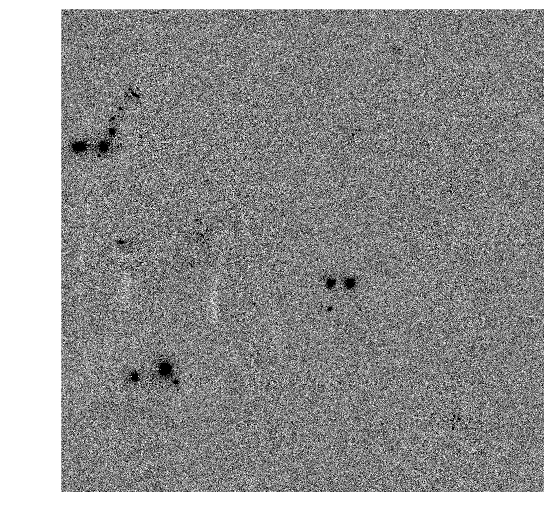

In [9]:
plt.figure(figsize=(6,6))
vmin, vmax = zscale(mi_clone.getImage().getArray())
plt.imshow(mi_clone.getImage().getArray(), vmin=vmin, origin='lower', 
           vmax=vmax, cmap=plt.cm.gray_r, aspect='equal')
plt.axis('off');

## View with ds9

In [10]:
disp.setMaskPlaneColor('DETECTED_NEGATIVE', 'magenta')
disp.setMaskPlaneColor('DETECTED', 'blue')
disp.setMaskTransparency(75)
disp.mtv(mi_clone)

with disp.Buffering():
    for foot in fp_hi.getFootprints():
        for p in foot.getPeaks():
            disp.dot('+', p.getCentroid()[0], p.getCentroid()[1], ctype=afwDisplay.GREEN)
    for foot in fp_lo.getFootprints():
        peaks = foot.getPeaks()
        points = np.array([(p.getCentroid()[0],p.getCentroid()[1]) for p in peaks])
        x, y = points.mean(axis=0)
        disp.dot('o', x, y, ctype=afwDisplay.RED)